In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['OPENAI_API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [2]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://note.com/hiroshikinoshita/n/n66e621ff6065',
  'content': '状態遷移の管理: LangGraphでは、各エージェントの状態を「ノード」として表現し、エージェント間の関係性や処理の流れを「エッジ」で定義します。これにより、複雑な処理を視覚的に整理しやすくなります。\n\n   マルチエージェントシステムの構築: LangGraphは、複数のエージェントが協調して動作するシステムの構築を容易にし、業務の効率化や精度向上を実現します。\n\n   柔軟なワークフロー設計: ステータス管理を組み合わせることで、動的なタスクの実行や条件に応じた処理の流れを構築できます。\n\n基本コンポーネント\n\nLangGraphは以下の基本コンポーネントから構成されています:\n\n1.   StateGraph: グラフ全体の状態を管理し、ノードとエッジを含むコンストラクションです。\n\n2.   Node: 各ステップや処理を実行するための要素。具体的なアクションや計算を行う関数として定義されます。\n\n3.   Edge: ノード間の接続を定義し、処理の流れや条件付きの遷移を管理します。\n\nLangGraphの使用方法\n\n使用方法は以下の通りです: [...] LangGraphは、状態遷移とワークフローの構築をシンプルに実現するPythonライブラリです。基本的な使い方としては、ノード間の依存関係をグラフとして定義し、状態（State）を流れるデータとして扱います。この構造により、複雑なデータの流れを可視化し、管理しやすくなります。特に、LangGraphはLangchainを基盤にしているため、Langchainの各種コンポーネントを活用してより複雑な大規模言語モデル（LLM）アプリケーションを構築することができます。\n\nさらに、LangGraphでは一般的なノード作成のほか、条件付きエッジを使用した分岐構造の実装が可能です。これにより、動的なルーティングや処理の流れを実現でき、AIエージェントが必要に応じて異なる処理を選択する柔軟性があります。\n\n例えば、Web検索エージェントと社員情報検索エージェントの選択が行えるようなシステムを構成する際に、ユーザーの質問に

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [5]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

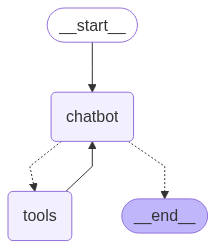

In [6]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは
こんにちは！今日はどんなことをお手伝いできますか？
1足す2は？
1足す2は3です。何か他に知りたいことがありますか？
1メートル以上の魚は？

[{"url": "https://tsurihack.com/8448", "content": "どの魚も、陸っぱりで狙えて最大全長が1mを超えるものばかり！\n\nお住まいの地域にこれからリストアップする魚が生息していたら、狙ってみてはいかがでしょうか。\n\n鯉｜もっとも手軽で簡単な大物\n\n難易度：★☆☆｜平均70cm、1m超えれば超絶レア\n魚釣り初心者の方にオススメしたいのは食パンを使ったコイ釣りです！\n\n安・近・短で手軽に釣ることができ、ボウズ（釣果ゼロ）で終わってしまうリスクも少ないのがパンコイゲームの魅力ですね。\n\n▼食パンを使ったコイの釣り方はこちら！\n針と餌だけのカンタン仕掛けで巨大魚が釣れる！？“パン鯉”に子供と挑戦してみました2023/04/27釣り好き！まっちゃん\n\n針と餌だけのカンタン仕掛けで巨大魚が釣れる！？“パン鯉”に子供と挑戦してみました\n\n2023/04/27釣り好き！まっちゃん\n\n1mを超えるコイは超絶レアですよ！\n\n身近な川魚のコイといえども最大サイズは1ｍを優に超え、コイを専門に狙う釣り人にとってメーター超えの巨鯉は一生に1匹でも良いから釣ってみたい憧れのサイズです。 [...] 最大で1mに迫るような大物を釣り狙う場合、例え身近な魚であっても釣り具の強度や仕掛け、ルアーの種類などをしっかり選ぶ必要があります。\n\n『この魚を釣ってみたい！』という確固たる目標を持って挑戦していく過程が大物釣り最大の醍醐味であり、準備や試行錯誤の期間が長い程、目標を手にした瞬間、つまり大物を釣り上げた瞬間の感動と達成感はなんとも言葉に表すことができないものになってきます。\n\n全身が震えたり、感情を抑えられず雄たけびやガッツポーズが出ちゃったりする……そんな体験を大人になっても味わえる。それが魚釣りの良い所だと僕は思っています。\n\n大物を釣り上げるまでの3ステップをお伝えします\n\nどんな大物を釣りたいか決めましょう\n\nまずは、自分の目標とする魚を設定しましょう。魚種でも良いですし、この魚の何センチ以上！　とかでも素敵な目標だと思います。\n